# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
!ls ../input/dog-dataset

dogImages  haarcascades  imagenet_class_index.json  images  lfw


In [2]:
import numpy as np
from glob import glob
import os
os.chdir('../input/dog-dataset')
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [3]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
img_short_side_resize = 256
img_input_size = 224
shuffle = True
num_workers = 16
batch_size = 64

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


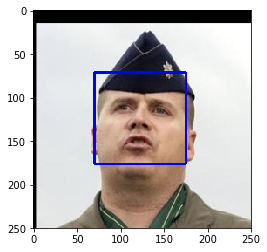

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
* Correct Human Faces in Human Faces ration : 99%
* Correct Human Faces in Dog Faces ration : 17%

In [6]:
def detect_faces(img_paths):
    faces_detected = np.zeros(len(img_paths))
    for i in range(len(img_paths)):
        faces_detected[i] = face_detector(img_paths[i])
    return faces_detected

In [7]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
faces_detected_human = detect_faces(human_files_short)
faces_detected_dog = detect_faces(dog_files_short)

In [8]:
print(f"{np.mean(faces_detected_human)*100:.3f}% of human faces found")
print(f"{np.mean(faces_detected_dog)*100:.3f}% of dogs confused with humans")

99.000% of human faces found
17.000% of dogs confused with humans


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [9]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [10]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)
# I'm loading some other models to compare them with the VGG16
VGG16_bn = models.vgg16_bn(pretrained=True)
alexnet = models.alexnet(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
resnet152 = models.resnet152(pretrained=True)
inception_v3 = models.inception_v3(pretrained=True)

# All these models will be used in evaluation mode 
model_list = [alexnet.eval(),VGG16.eval(),VGG16_bn.eval(),resnet18.eval(),resnet152.eval(),inception_v3.eval()]
model_names = ["alexnet","VGG16","VGG16_bn","resnet18","resnet152","inception_v3"]

# check if CUDA is available
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda:0")
    print("Using",torch.cuda.get_device_name(device))
    
VGG16 = VGG16.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s]
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /tmp/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:05<00:00, 109MB/s]
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /tmp/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:02<00:00, 99.7MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.1MB/s]
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:02<00:00, 113MB/s]
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /tmp/.cache/torch

CUDA is available!  Training on GPU ...
Using Tesla P100-PCIE-16GB


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [11]:
def im_convert(tensor):
    """ Display a tensor as an image. """    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

def show_image_from_path(img_path, title = None):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    if title is not None:
        plt.gca().set_title(title)
    plt.show()

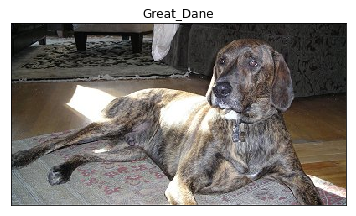

In [12]:
from PIL import Image
import torchvision.transforms as transforms
import json
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

def model_predict(img_path, model, device):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    ''' 
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path).convert('RGB')
    # To avoid changing the aspect ratio of the image we can use the FiveCrop transform, which returns the center and the 
    # corner crops. Five outputs are calculated and then averaged.
    in_transform = transforms.Compose([
                        transforms.Resize(img_short_side_resize),  
                        transforms.FiveCrop(img_input_size),
                        transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                    transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])        
    
    output = torch.argmax(model(in_transform(image).to(device)).mean(0))
   
    return output.to("cpu").item() # predicted class index


test_image = dog_files_short[0]
pred = model_predict(test_image, VGG16, device)
show_image_from_path(test_image, title = idx2label[pred])

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, model, device):
    ## TODO: Complete the function.
    out = model_predict(img_path,model,device)
    return out >= 151 and out <= 268 # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
* Correct Dog Faces in Dog Faces ration : 98%
* Correct Dog Faces in Human Faces ration : 2%

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogs_detected_correctly = [dog_detector(img_path,VGG16,device) for img_path in dog_files_short]
dogs_detected_incorrectly = [dog_detector(img_path,VGG16,device) for img_path in human_files_short]

tpr_vgg16 = np.mean(dogs_detected_correctly)
fpr_vgg16 = np.mean(dogs_detected_incorrectly)

print(f"VGG16: {fpr_vgg16 * 100:.3f}% of humans confused with dogs")
print(f"VGG16: {tpr_vgg16 * 100:.3f}% dogs correctly identified")

VGG16: 2.000% of humans confused with dogs
VGG16: 98.000% dogs correctly identified


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [15]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

VGG16 = VGG16.to("cpu")
torch.cuda.empty_cache()
tpr = np.zeros(len(model_list))
fpr = np.zeros(len(model_list))
for i in range(len(model_list)):
    model = model_list[i].to(device)
    tpr[i] = np.mean([dog_detector(img_path, model, device) for img_path in dog_files_short])
    fpr[i] = np.mean([dog_detector(img_path, model, device) for img_path in human_files_short])
    model = model.to("cpu")

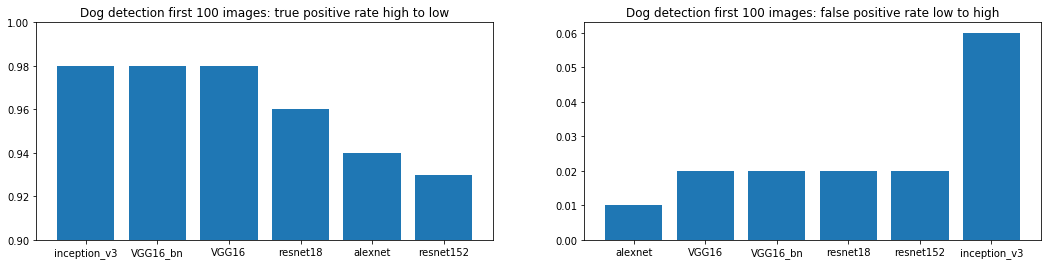

In [16]:
# Sort the tpr and fpr
idx_tpr = np.argsort(tpr)[::-1]
idx_fpr = np.argsort(fpr)

fig,ax = plt.subplots(1,2,figsize = (18,4))
ax[0].bar([model_names[i] for i in idx_tpr],tpr[idx_tpr])
ax[0].set_title(f"Dog detection first 100 images: true positive rate high to low")
ax[0].set_ylim((0.9,1))
ax[1].bar([model_names[i] for i in idx_fpr],fpr[idx_fpr])
ax[1].set_title("Dog detection first 100 images: false positive rate low to high")
plt.show()

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [17]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_input_size),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])

train_data = datasets.ImageFolder("./dogImages/train/",transform_train)
valid_data = datasets.ImageFolder("./dogImages/valid/",transform_test)
test_data = datasets.ImageFolder("./dogImages/test/",transform_test)
data = {"train" : train_data, "valid" : valid_data, "test" : test_data}
n_classes = len(train_data.classes)

# Create the data loaders
train_loader = torch.utils.data.DataLoader(data["train"], batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=shuffle, pin_memory=True)
# If using the 5crop test time augmentation num_workers must be set to 0 otherwise we get an error. 
# The batch size during testing must also be reduced to keep memory requirements
valid_loader = torch.utils.data.DataLoader(data["valid"], batch_size=int(np.floor(batch_size/5)), 
                                           num_workers=0, shuffle=shuffle, pin_memory=True)
test_loader = torch.utils.data.DataLoader(data["test"], batch_size=int(np.floor(batch_size/5)), 
                                          num_workers=0, shuffle=shuffle, pin_memory=True)
loaders_scratch = {"train" : train_loader, "valid" : valid_loader, "test" : test_loader}

In [18]:
learning_rates = 5e-4 * np.logspace(0,1.5,9)
learning_rate = learning_rates[2]

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
* I have used data augmentation step with Random Resize crop with small crops. Like in different time models can learn different angles and faces of images like face, tail, feet and other parts. So data augmentation is important. 
* I have used Random Resized Crop to crop the image from different angles like the top, bottom, left, right and center. We must have to maintain the aspect ratio of 224x224 because we have defined tensor. 
* I used horizontal flips because most of the dogs have faces left or right. There is no need for vertical fips because mostly all dogs are upside down. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [19]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, n_classes, depth_1 = 32):
        super(Net, self).__init__()        
        # Keep track of things
        depth_2 = depth_1 * 2
        depth_3 = depth_2 * 2      
        # Max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # Conv set 1
        self.conv1_1 = nn.Conv2d(3,depth_1,3,stride = 1,padding = 1)
        self.conv1_2 = nn.Conv2d(depth_1,depth_1,3,stride = 1,padding = 1)
        self.bn1_1 = nn.BatchNorm2d(depth_1)
        self.bn1_2 = nn.BatchNorm2d(depth_1)
        # Conv set 2
        self.conv2_1 = nn.Conv2d(depth_1,depth_2,3,stride = 1,padding = 1)
        self.conv2_2 = nn.Conv2d(depth_2,depth_2,3,stride = 1,padding = 1)
        self.bn2_1 = nn.BatchNorm2d(depth_2)
        self.bn2_2 = nn.BatchNorm2d(depth_2)        
        # Conv set 3
        self.conv3_1 = nn.Conv2d(depth_2,depth_3,3,stride = 1,padding = 1)
        self.conv3_2 = nn.Conv2d(depth_3,depth_3,3,stride = 1,padding = 1)
        self.bn3_1 = nn.BatchNorm2d(depth_3)
        self.bn3_2 = nn.BatchNorm2d(depth_3)
        # Output
        self.fc_out = nn.Linear(depth_3,n_classes)   
        # Initialize weights
        nn.init.kaiming_normal_(self.conv1_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv1_2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2_2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3_2.weight, nonlinearity='relu') 
            
    def forward(self, x):
        # Conv 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool(x)
        # Conv 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool(x)
        # Conv 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool(x)
        # First we fuse the height and width dimensions (2 and 3) 
        x = x.view(x.size(0),x.size(1),-1)        
        # And now max global pooling
        x = x.max(2)[0]
        # Output
        x = self.fc_out(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net(n_classes)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

* I have used a similar kind of network like VGG. I have added 2 convolutional layers followed by max pooling. Depth is double after each max pooling to maintain computation cost. 
* I have replaced fully connected layers with the max Pooling layer. I have used Max pooling rather than average pooling layers because I have experimented from_scratch and there I found that Max pooling works better than Average pooling layer. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [20]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(),learning_rate) 

### Let's add a learning rate scheduler
scheduler_scratch = ReduceLROnPlateau(optimizer_scratch, 'min', verbose = True)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [21]:
import time

def train_epoch(model,train_loader,optimizer,criterion,device):
    train_loss = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move to GPU
        data, target = data.to(device), target.to(device)
        # Set gradients to 0
        optimizer.zero_grad()
        # Get output
        output = model(data)               
        # Calculate loss
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)
        # Calculate gradients
        loss.backward()
        # Take step
        optimizer.step()    
    train_loss = train_loss / len(train_loader.dataset)
    return model, train_loss
        
def valid_epoch(model,valid_loader,criterion,device,fivecrop):
    ######################    
    # validate the model #
    ######################
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            # move to GPU
            data, target = data.to(device), target.to(device)
            # if we do test time augmentation with 5crop we'll have an extra dimension in our tensor
            if fivecrop == "mean":
                bs, ncrops, c, h, w = data.size()
                output = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
                output = output.view(bs, ncrops, -1).mean(1)
            elif fivecrop == "max":
                bs, ncrops, c, h, w = data.size()
                output = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
                output = output.view(bs, ncrops, -1).max(1)[0]
            else:
                output = model(data)
            ## update the average validation loss
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
    valid_loss = valid_loss / len(valid_loader.dataset) 
    return valid_loss

def train(n_epochs, loaders, model, optimizer, criterion, device, path_model, fivecrop = None, lr_scheduler = None):
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_loss = []
    valid_loss = []
    # Time everything
    time_start = time.time()
    for epoch in range(1, n_epochs+1):
        time_start_epoch = time.time()    
        # Train this epoch
        model, train_loss_epoch = train_epoch(model,loaders["train"],optimizer,criterion,device)
        train_loss.append(train_loss_epoch)   
        # Validate this epoch
        valid_loss_epoch = valid_epoch(model,loaders["valid"],criterion,device,fivecrop)
        # Call the learning rate scheduler if we have one
        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss_epoch)
        valid_loss.append(valid_loss_epoch)  
        # Save if validation loss is the lowest so far
        if valid_loss_epoch <= valid_loss_min:
            torch.save(model.state_dict(), path_model)
            valid_loss_min = valid_loss_epoch 
        # Print epoch statistics
        print('Epoch {} done in {:.2f} seconds. \tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format(
            epoch,             
            time.time() - time_start_epoch,
            train_loss_epoch,
            valid_loss_epoch
            ))   
    # Show final statistics    
    print(f"{n_epochs} epochs ready in {(time.time() - time_start):.3f} seconds. Minimum validation loss: {valid_loss_min:.3f}")
    # Load best config
    model.load_state_dict(torch.load(path_model))
    return model


In [22]:
# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, 
                      device, '../model_scratch.pt', fivecrop = "mean", lr_scheduler = scheduler_scratch)

Epoch 1 done in 154.18 seconds. 	Training Loss: 5.005 	Validation Loss: 4.861
Epoch 2 done in 152.77 seconds. 	Training Loss: 4.797 	Validation Loss: 4.751
Epoch 3 done in 153.32 seconds. 	Training Loss: 4.702 	Validation Loss: 4.632
Epoch 4 done in 155.65 seconds. 	Training Loss: 4.623 	Validation Loss: 4.708
Epoch 5 done in 154.60 seconds. 	Training Loss: 4.556 	Validation Loss: 4.662
Epoch 6 done in 153.23 seconds. 	Training Loss: 4.479 	Validation Loss: 4.706
Epoch 7 done in 160.22 seconds. 	Training Loss: 4.437 	Validation Loss: 4.457
Epoch 8 done in 165.81 seconds. 	Training Loss: 4.378 	Validation Loss: 4.388
Epoch 9 done in 166.27 seconds. 	Training Loss: 4.276 	Validation Loss: 4.215
Epoch 10 done in 166.59 seconds. 	Training Loss: 4.205 	Validation Loss: 4.114
Epoch 11 done in 164.67 seconds. 	Training Loss: 4.126 	Validation Loss: 4.099
Epoch 12 done in 163.35 seconds. 	Training Loss: 4.048 	Validation Loss: 3.968
Epoch 13 done in 164.79 seconds. 	Training Loss: 3.977 	Valid

In [23]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('../model_scratch.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [24]:
def test(loaders, model, criterion, device):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            data, target = data.to(device), target.to(device)
            bs, ncrops, c, h, w = data.size()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
            output = output.view(bs, ncrops, -1).mean(1)        
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [25]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, device)

Test Loss: 1.661397


Test Accuracy: 54% (455/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [26]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [27]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 113MB/s]


In [28]:
# Freezing all parameters
for param in model_transfer.parameters():
    param.requires_grad = False

In [29]:
# Replacing the last layer (by default it will have requires_grad == True)
model_transfer.fc = nn.Linear(model_transfer.fc.in_features,n_classes)
# Initialize the weights of the new layer
nn.init.kaiming_normal_(model_transfer.fc.weight, nonlinearity='relu')
# Transfer to GPU 
model_transfer = model_transfer.to(device)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
* Resnet is already well-used model architecture in major applications. It's mostly good to work with transfer learning and updating the last layers based on your requirements. Here we are doing the same. We are using an already pre-trained model that has awesome accuracy and updating the weights of the last layers with our training. 
* I have used Cross-Entropy Loss because I have experimented with different loss functions with small epochs and do comparative analysis and Cross-Entropy works fine with it. Because It focuses on the correct result and gives more weight to it. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [30]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(),3e-4) 
scheduler_transfer = ReduceLROnPlateau(optimizer_transfer, 'min', verbose = True, factor = 0.5, patience = 7)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [31]:
# train the model
model_transfer = train(100, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, device, '../model_transfer.pt', fivecrop = "mean", lr_scheduler = scheduler_transfer)

Epoch 1 done in 144.45 seconds. 	Training Loss: 4.011 	Validation Loss: 2.637
Epoch 2 done in 145.67 seconds. 	Training Loss: 2.502 	Validation Loss: 1.543
Epoch 3 done in 144.83 seconds. 	Training Loss: 1.835 	Validation Loss: 1.097
Epoch 4 done in 145.95 seconds. 	Training Loss: 1.518 	Validation Loss: 0.896
Epoch 5 done in 146.92 seconds. 	Training Loss: 1.341 	Validation Loss: 0.765
Epoch 6 done in 148.31 seconds. 	Training Loss: 1.236 	Validation Loss: 0.670
Epoch 7 done in 146.53 seconds. 	Training Loss: 1.119 	Validation Loss: 0.628
Epoch 8 done in 145.05 seconds. 	Training Loss: 1.068 	Validation Loss: 0.576
Epoch 9 done in 143.89 seconds. 	Training Loss: 1.000 	Validation Loss: 0.552
Epoch 10 done in 145.65 seconds. 	Training Loss: 0.964 	Validation Loss: 0.523
Epoch 11 done in 144.78 seconds. 	Training Loss: 0.950 	Validation Loss: 0.504
Epoch 12 done in 145.62 seconds. 	Training Loss: 0.915 	Validation Loss: 0.494
Epoch 13 done in 144.21 seconds. 	Training Loss: 0.901 	Valid

In [32]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('../model_transfer.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [33]:
test(loaders_transfer, model_transfer, criterion_transfer, device)

Test Loss: 0.362001


Test Accuracy: 88% (736/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

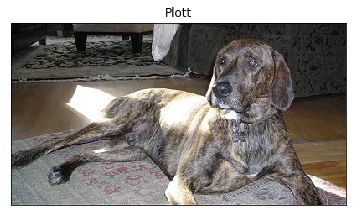

In [34]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data['train'].classes]

def predict_breed_transfer(img_path, model, device):
    # load the image and return the predicted breed
    image = Image.open(img_path).convert('RGB')
    
    # Resnet replaces the fully connected layer with global average pooling. Theoretically then, 
    # it should work with any input size, since the result of the global pooling depends only on 
    # the number of filters and not on their spatial dimensions. Unfortunately, the provided 
    # torchvision model implements global pooling as a regular average pooling in which the kernel
    # size is equal to the spatial size of the filters (in this case 7). So we still need to apply the
    # FiveCrop transform if we want to keep the aspect ratio and not only crop the center.
    
    in_transform = transforms.Compose([
                        transforms.Resize(img_short_side_resize),  
                        transforms.FiveCrop(img_input_size),
                        transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                    transforms.ToTensor(),transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])        
    
    scores = model(in_transform(image).to(device)).mean(0)
    output = torch.argmax(scores)
   
    return output.to("cpu").item(), F.softmax(scores,dim=0).to("cpu").data.numpy() # predicted class index

test_image = dog_files_short[0]
pred,probs = predict_breed_transfer(test_image, model_transfer, device)
show_image_from_path(test_image, title = class_names[pred])


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [35]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def show_image_with_pie(img_path,title_picture,title_pie,likely_breeds,likely_probs):
    # Read the image
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  
    # Show the image
    if title_pie is None:
        fig, ax = plt.subplots(figsize=(12,4))  
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])       
        ax.set_title(title_picture)
    else:
        fig, ax = plt.subplots(1,2,figsize=(10,4))  
        ax[0].imshow(img)
        ax[0].set_xticks([])
        ax[0].set_yticks([])   
        ax[0].set_title(title_picture)
        wedges, texts, autotexts = ax[1].pie(likely_probs, 
                                             autopct='%1.1f%%', wedgeprops = {'linewidth': 0})
        ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax[1].legend(wedges, likely_breeds, title="Likely breeds",
                     loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))    
        ax[1].set_title(title_pie)
    plt.show()    
    
def process_probs(pred, probs, threshold = 0.01, max_n = 4):
    # Let's discard unlikely breeds
    selection = probs > threshold
    likely_breeds = [breed for (breed, detected) in zip(class_names, selection) if detected]
    likely_probs = [prob for (prob, detected) in zip(probs, selection) if detected]    

    order = np.argsort(np.array(likely_probs))[::-1]
    likely_breeds = [likely_breeds[int(i)] for i in order]
    likely_probs = [likely_probs[int(i)] for i in order]
    likely_breeds = likely_breeds[:max_n]
    likely_probs = likely_probs[:max_n]
    
    # And let's fill the discarded gap with "other" (if there is a gap)
    if len(likely_breeds) > 1:
        likely_breeds = likely_breeds + ["Other"]
        likely_probs = likely_probs + [1 - sum(likely_probs)]
    else:
        # If no other breed is predicted with at least 1% let's round up the confidence to 100% 
        likely_probs = [100]
        
    return likely_breeds, likely_probs

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
      
    # Check if a dog is detected
    dog_detected = dog_detector(img_path,model_dog_detector,device)
    # Check if a human is detected
    human_detected = face_detector(img_path)
    # Get the predicted breed(s)
    pred, probs = predict_breed_transfer(img_path, model_transfer, device)
    # Process class probabilities (remove very low probabilities and replace with "other", sort them etc)
    likely_breeds, likely_probs = process_probs(pred, probs)
    # Decide on titles and such
    if dog_detected and not human_detected:
        title_picture = f"Who's a good doggie?\nThis {class_names[pred]} is!"
        if len(likely_breeds) == 1:
            title_pie = "A purebred!"
        else:
            title_pie = "Interesting mix we've got here..."
    elif not dog_detected and human_detected:
        title_picture = f"Hello there!\nYou look like a {class_names[pred]}!"
        title_pie = "Here are all the dog breeds you look like:"        
    elif dog_detected and human_detected:
        title_picture = f"Hello human, that's a nice {class_names[pred]} you've got there!"
        if len(likely_breeds) == 1:
            title_pie = "A purebred!"
        else:
            title_pie = "Interesting mix we've got here..."        
    else:
        title_picture = "That's a nice picture but I can't find any dogs or humans here..."
        title_pie = None
        
    # Show everything
    show_image_with_pie(img_path,title_picture,title_pie,likely_breeds,likely_probs)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

* This model meets my expectations of the detection of humans and dogs. 
* To get the better output we have to feed with a combination of dogs and human faces present in the same images. Because it will help the model to improve and accept a different variety of input data. Working with good combination of humans and dogs will help to improve accuracy. 
* We can use a combination of 2 or more models. Ex. Some model works good with Human and some model work good with DOg so we can make a combination of that 2 models which might give good results. Like Ada Boost and other techniques. 
* We have to use other more complex architecture or different models from Fast AI or TensorFlow. It might give good results. But still, we have to do some experiments. 
* To make it better we have to work with more advanced methods like Generative Adversarial Network but for that, we have to do some hands-on experiment. 


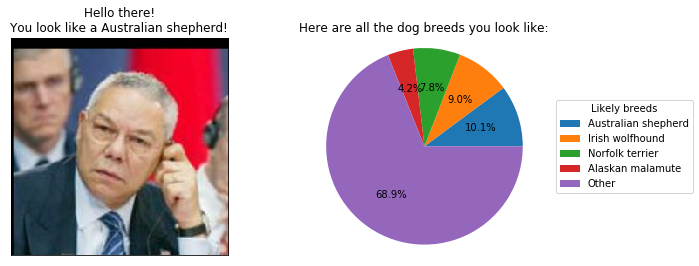

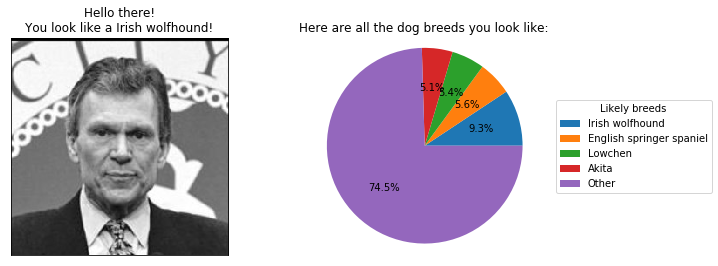

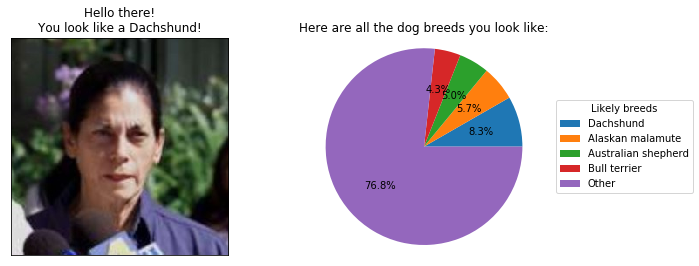

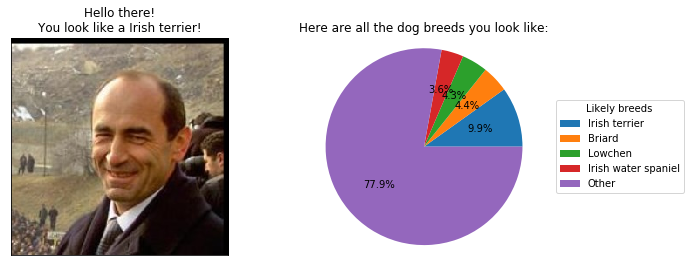

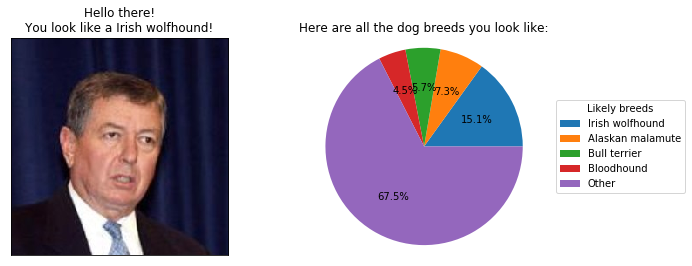

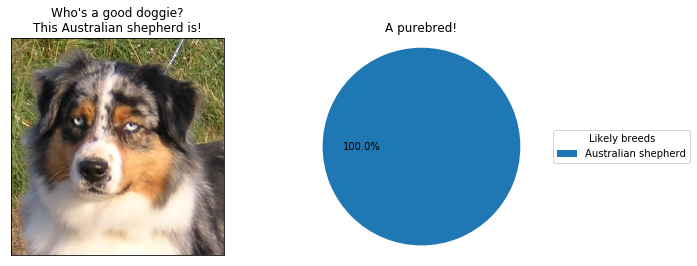

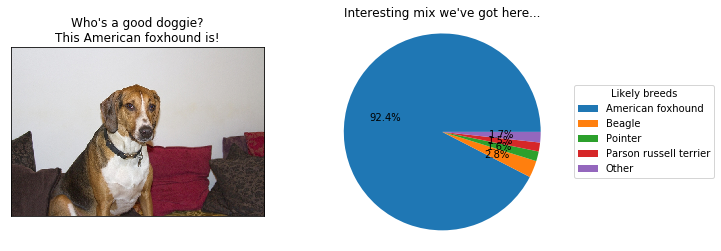

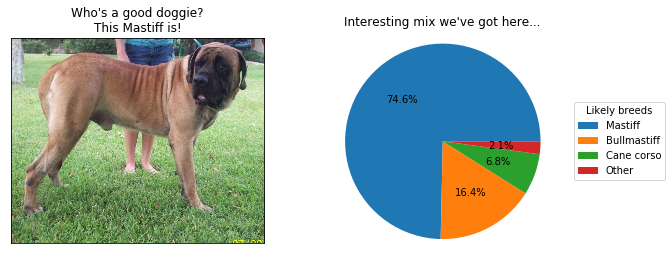

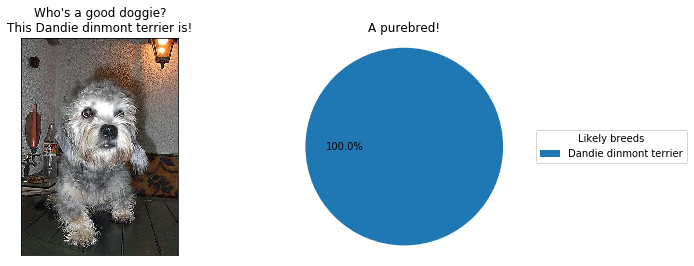

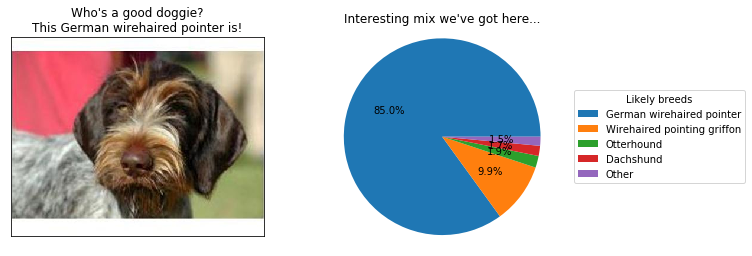

In [36]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

# First make sure we have all the models on the GPU
model_dog_detector = alexnet # Alexnet weirdly turned out to be the best dog detector
model_dog_detector = model_dog_detector.to(device)

## suggested code, below
# Get 10 random images of each type
selection_human = np.random.randint(0,high=len(human_files),size=5)
selection_dogs = np.random.randint(0,high=len(dog_files),size=5)
for file in np.hstack((human_files[selection_human], dog_files[selection_dogs])):
    run_app(file)

In [37]:
from IPython.display import FileLink, FileLinks
FileLinks('../') #lists all downloadable files on server

../
  model_transfer.pt
  model_scratch.pt
../dog-dataset/
  imagenet_class_index.json
../dog-dataset/dogImages/test/001.Affenpinscher/
  Affenpinscher_00078.jpg
  Affenpinscher_00071.jpg
  Affenpinscher_00047.jpg
  Affenpinscher_00003.jpg
  Affenpinscher_00058.jpg
  Affenpinscher_00048.jpg
  Affenpinscher_00023.jpg
  Affenpinscher_00036.jpg
../dog-dataset/dogImages/test/002.Afghan_hound/
  Afghan_hound_00149.jpg
  Afghan_hound_00141.jpg
  Afghan_hound_00139.jpg
  Afghan_hound_00146.jpg
  Afghan_hound_00143.jpg
  Afghan_hound_00151.jpg
  Afghan_hound_00116.jpg
  Afghan_hound_00125.jpg
../dog-dataset/dogImages/test/003.Airedale_terrier/
  Airedale_terrier_00214.jpg
  Airedale_terrier_00166.jpg
  Airedale_terrier_00179.jpg
  Airedale_terrier_00175.jpg
  Airedale_terrier_00207.jpg
  Airedale_terrier_00210.jpg
../dog-dataset/dogImages/test/004.Akita/
  Akita_00262.jpg
  Akita_00296.jpg
  Akita_00263.jpg
  Akita_00270.jpg
  Akita_00282.jpg
  Akita_00276.jpg
  Akita_00258.jpg
  Akita_00244.jpg
../dog-dataset/dogImages/test/005.Alaskan_malamute/
  Alaskan_malamute_00309.jpg
  Alaskan_malamute_00354.jpg
  Alaskan_malamute_00362.jpg
  Alaskan_malamute_00330.jpg
  Alaskan_malamute_00386.jpg
  Alaskan_malamute_00387.jpg
  Alaskan_malamute_00360.jpg
  Alaskan_malamute_00383.jpg
  Alaskan_malamute_00346.jpg
  Alaskan_malamute_00375.jpg
../dog-dataset/dogImages/test/006.American_eskimo_dog/
  American_eskimo_dog_00451.jpg
  American_eskimo_dog_00406.jpg
  American_eskimo_dog_00407.jpg
  American_eskimo_dog_00467.jpg
  American_eskimo_dog_00415.jpg
  American_eskimo_dog_00454.jpg
  American_eskimo_dog_00452.jpg
  American_eskimo_dog_00471.jpg
../dog-dataset/dogImages/test/007.American_foxhound/
  American_foxhound_00484.jpg
  American_foxhound_00519.jpg
  American_foxhound_00531.jpg
  American_foxhound_00512.jpg
  American_foxhound_00524.jpg
  American_foxhound_00535.jpg
  American_foxhound_00522.jpg
../dog-dataset/dogImages/test/008.American_staffordshire_terrier/
  American_staffordshire_terrier_00538.jpg
  American_staffordshire_terrier_00539.jpg
  American_staffordshire_terrier_00556.jpg
  American_staffordshire_terrier_00580.jpg
  American_staffordshire_terrier_00579.jpg
  American_staffordshire_terrier_00540.jpg
  American_staffordshire_terrier_00567.jpg
  American_staffordshire_terrier_00607.jpg
../dog-dataset/dogImages/test/009.American_water_spaniel/
  American_water_spaniel_00646.jpg
  American_water_spaniel_00655.jpg
  American_water_spaniel_00631.jpg
  American_water_spaniel_00624.jpg
../dog-dataset/dogImages/test/010.Anatolian_shepherd_dog/
  Anatolian_shepherd_dog_00695.jpg
  Anatolian_shepherd_dog_00669.jpg
  Anatolian_shepherd_dog_00673.jpg
  Anatolian_shepherd_dog_00690.jpg
  Anatolian_shepherd_dog_00710.jpg
  Anatolian_shepherd_dog_00661.jpg
../dog-dataset/dogImages/test/011.Australian_cattle_dog/
  Australian_cattle_dog_00727.jpg
  Australian_cattle_dog_00761.jpg
  Australian_cattle_dog_00788.jpg
  Australian_cattle_dog_00734.jpg
  Australian_cattle_dog_00792.jpg
  Australian_cattle_dog_00781.jpg
  Australian_cattle_dog_00730.jpg
  Australian_cattle_dog_00728.jpg
  Australian_cattle_dog_00803.jpg
../dog-dataset/dogImages/test/012.Australian_shepherd/
  Australian_shepherd_00887.jpg
  Australian_shepherd_00830.jpg
  Australian_shepherd_00853.jpg
  Australian_shepherd_00868.jpg
  Australian_shepherd_00843.jpg
  Australian_shepherd_00864.jpg
  Australian_shepherd_00870.jpg
  Australian_shepherd_00836.jpg
  Australian_shepherd_00848.jpg
../dog-dataset/dogImages/test/013.Australian_terrier/
  Australian_terrier_00900.jpg
  Australian_terrier_00930.jpg
  Australian_terrier_00897.jpg
  Australian_terrier_00918.jpg
  Australian_terrier_00925.jpg
  Australian_terrier_00923.jpg
../dog-dataset/dogImages/test/014.Basenji/
  Basenji_00987.jpg
  Basenji_00955.jpg
  Basenji_00974.jpg
  Basenji_00978.jpg
  Basenji_00985.jpg
  Basenji_00959.jpg
  Basenji_01009.jpg
  Basenji_01029.jpg
  Basenji_00961.jpg
../dog-dataset/dogImages/test/015.Ba